In [75]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [76]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [77]:
OB = 'OB5'

In [100]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[4]).T
#x= np.array([wl, flux, error,error]).T
#exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
#          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
#          (x[:,0] > 3600) & (x[:,0] < 22500)

exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 5555) & (x[:,0] < 23500)
wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

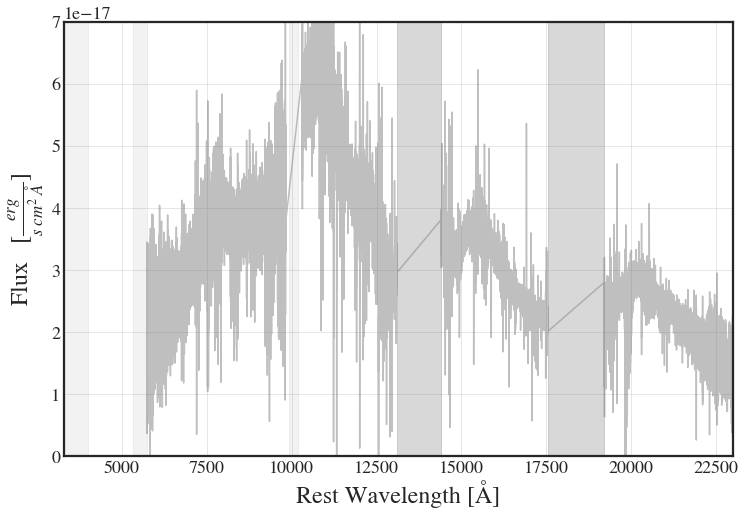

In [101]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 0.7e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [80]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit
beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [81]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [102]:
#p = lmfit.Parameters()
#OB = 'OB5'
#with open("./data/%s_init.json"%OB, 'r') as infile:
#    p.load(infile)
pickle_in = open("./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params


start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 1.1742975195248921


In [103]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=5.4), mi2.params['ve'], mi2.params['vphot']

(42.77183832518561,
 <Parameter 've', value=0.3308631486208735, bounds=[0:1]>,
 <Parameter 'vphot', value=0.14514941363818795, bounds=[0:1]>)

In [111]:
print(lum_dist_arr(p['N'],p['vphot'],n_days=4.40), p['ve'], p['vphot'])
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g = Gaussian1DKernel(stddev=5)

34.85112752422531 <Parameter 've', value=0.3308631486208735, bounds=[0:1]> <Parameter 'vphot', value=0.14514941363818795, bounds=[0:1]>


In [112]:
with open("./data/%s_without_UV.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

(Text(0, 0.5, '$F_\\lambda  [10^{-17} \\frac{erg}{s \\ cm^2 \\ Å} ] $'),)

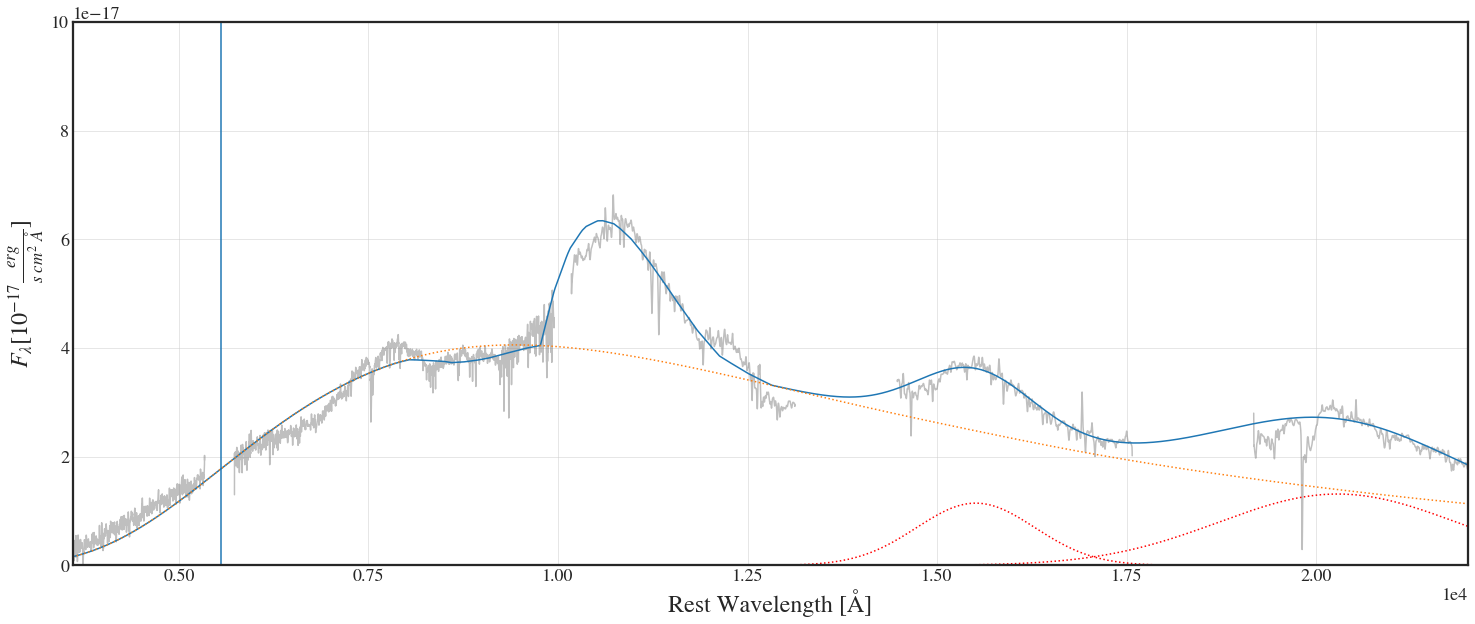

In [114]:
p = lmfit.Parameters()
with open("./Data/%s_without_UV.json"%OB, 'r') as infile:
    p.load(infile)
#p
lum_dist_arr(p['N'],p['vphot'],n_days=3.45), p['ve'], p['vphot']


path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)


i = 3
plt.figure(figsize=(25,10))

for i in [4]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan

    
    amp1 = np.copy(gaussian(wl2, 1e-17*p['amp1'].value, p['cen1'].value*1e10, p['sig1'].value*1e10))
    amp2 = gaussian(wl2, 1e-17*p['amp2'].value, p['cen2'].value*1e10, p['sig2'].value*1e10)
    
    flux_fit = residual(p, wl2*1e-10)
    p['tau'].value=0
    flux_fit2 = residual(p, wl2*1e-10)
    p['amp1'].value=0
    p['amp2'].value=0
    flux_fit3 = residual(p, wl2*1e-10)

    
#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
    #plt.plot(wl2, flux_fit2)
    plt.plot(wl2, flux_fit3, ls='dotted')
    plt.plot(wl2, amp1, ls='dotted', color='red')
    plt.plot(wl2, amp2, ls='dotted', color='red')
    

plt.xlim(3600, 22000)
plt.ylim(0, 1e-16) 
plt.axvline(5555)
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $'), 
#plt.axvline(15500)
#plt.axvline(15250, ls='--')
#plt.savefig('Pictures/third_line.png', dpi=300)

In [106]:
p

name,value,initial value,min,max,vary


In [13]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=5.45), mi2.params['ve'], mi2.params['vphot']

(33.60762497452364,
 <Parameter 've', value=0.202291798392972, bounds=[0:1]>,
 <Parameter 'vphot', value=0.13992172374968564, bounds=[0:1]>)

In [14]:
with open("./data/%s_1.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [16]:
p = lmfit.Parameters()
with open("./Data/%s_1.json"%OB, 'r') as infile:
    p.load(infile)

#p
lum_dist_arr(p['N'],p['vphot'],n_days=5.45), p['ve'], p['vphot']

(33.60762497452364,
 <Parameter 've', value=0.202291798392972, bounds=[0:1]>,
 <Parameter 'vphot', value=0.13992172374968564, bounds=[0:1]>)

In [68]:
pickle_in = open("./Data/OB5/OB5_3_peaks_with_gaussian.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=5.4), p['ve'], p['vphot'])
#p['ve'].max = 10
#p['amp1'].min = 0; p['amp2'].min = 0; 
#p['amp1'].vary=True; p['amp2'].vary=True; 
#p['sig1'].vary=True; p['sig2'].vary=True; 
#p['amp1'].value = 0.1; p['amp2'].value = 0.1;
#p['cen2'].value=2.03e-6; #p['sig2'].value=7.2e-8; 

#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].min = -1; p['amp2'].min = -1; p['amp1'].value = 0.001; p['amp2'].value = 0.001; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
p['cen1'].vary=True; p['cen2'].vary=True; 
p['cen2'].value = 2.0e-6
p['occult'].max = 40
#p['vphot'].vary = True; p['vmax'].vary = True
p

43.20104786995618 <Parameter 've', value=0.3289573444095824 +/- 0.0485, bounds=[0:1]> <Parameter 'vphot', value=0.14640500352296562 +/- 0.00268, bounds=[0:1]>


name,value,standard error,relative error,initial value,min,max,vary
T,3072.90629,4.42349125,(0.14%),3057.2164816193535,2500.00000,7500.00000,True
N,3.6178e-29,3.3361e-31,(0.92%),3.7414525773663946e-29,-inf,inf,True
vphot,0.14640500,0.00267971,(1.83%),0.1487510652639866,0.00000000,1.00000000,True
vmax,0.21940724,0.00400186,(1.82%),0.22292413038598052,0.00000000,1.00000000,True
t0,471600.000,,(1.82%),471600,-inf,inf,False
tau,0.15889246,0.02214371,(13.94%),0.18190151054151232,0.00000000,10.0000000,True
vref,0.00000000,,(13.94%),0.0,0.00000000,1.00000000,False
ve,0.32895734,0.04850165,(14.74%),0.2950162644425349,0.00000000,1.00000000,True
occult,22.2649308,1.11679398,(5.02%),19.885019152196143,0.10000000,40.0000000,True
amp1,1.15425954,0.00922815,(0.80%),1.117233132710017,0.01000000,5.00000000,True


In [90]:
pickle_in = open("./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

#p['sig1'].value = 0.55e-7; p['sig2'].value = 1.10e-7; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
p['amp1'].min = 0; p['amp2'].min = 0; 
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 
p['amp1'].value = 0.0; p['amp2'].value = 0.0;
#p['cen2'].value=2.03e-6; p['sig2'].value=7.2e-8; 

p

name,value,standard error,relative error,initial value,min,max,vary
T,3074.44908,4.05048285,(0.13%),3072.9062936578944,2500.00000,7500.00000,True
N,3.6091e-29,3.7977e-31,(1.05%),3.617769596181866e-29,-inf,inf,True
vphot,0.14629930,1.2770e-04,(0.09%),0.14640500352296562,0.00000000,1.00000000,True
vmax,0.21924834,1.9094e-04,(0.09%),0.21940724330370415,0.00000000,1.00000000,True
t0,471600.000,,(0.09%),471600,-inf,inf,False
tau,0.16020896,6.1667e-04,(0.38%),0.15889245689963946,0.00000000,10.0000000,True
vref,0.00000000,,(0.38%),0.0,0.00000000,1.00000000,False
ve,0.32905074,0.05398227,(16.41%),0.3289573444095824,0.00000000,1.00000000,True
occult,22.3658589,2.63707303,(11.79%),22.264930789253874,0.10000000,40.0000000,True
amp1,0.00000000,0.01285254,(inf%),1.1542595378679568,0.00000000,5.00000000,False


#### Markov Chain Monto Carlo to sample distribution

In [91]:
mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 100 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB5/OB5_3_peaks_XL_3.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 2000/2000 [2:27:57<00:00,  4.44s/it]   


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [260.40670911 266.23679384 196.24451574 186.37098172 205.12677614
 243.9063584  247.50588919]
Time elapsed [hours]: 2.4674543935722775


In [97]:
with open("./Data/OB5/OB5_3_peaks_lambda_13000_1.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 

In [99]:
res2.acceptance_fraction

array([0.058 , 0.0575, 0.0475, 0.0575, 0.061 , 0.064 , 0.065 , 0.0615,
       0.068 , 0.036 , 0.0455, 0.0805, 0.021 , 0.0675, 0.0335, 0.06  ,
       0.058 , 0.0475, 0.049 , 0.0695, 0.042 , 0.047 , 0.0375, 0.113 ,
       0.0835, 0.048 , 0.0675, 0.0645, 0.0615, 0.062 , 0.042 , 0.0655,
       0.0555, 0.081 , 0.0775, 0.067 , 0.05  , 0.0575, 0.028 , 0.082 ,
       0.062 , 0.0705, 0.0525, 0.0525, 0.0285, 0.0555, 0.096 , 0.0285,
       0.0575, 0.0415, 0.0595, 0.0605, 0.051 , 0.0625, 0.0525, 0.0535,
       0.083 , 0.0635, 0.05  , 0.0565, 0.0495, 0.062 , 0.0325, 0.0745,
       0.068 , 0.051 , 0.0515, 0.0785, 0.0775, 0.0565, 0.045 , 0.0525,
       0.0465, 0.0775, 0.094 , 0.0665, 0.0465, 0.0415, 0.051 , 0.0595,
       0.0685, 0.0395, 0.0435, 0.039 , 0.0335, 0.053 , 0.052 , 0.069 ,
       0.055 , 0.064 , 0.023 , 0.0525, 0.061 , 0.068 , 0.051 , 0.041 ,
       0.047 , 0.047 , 0.073 , 0.053 ])

(0.146, 0.148)

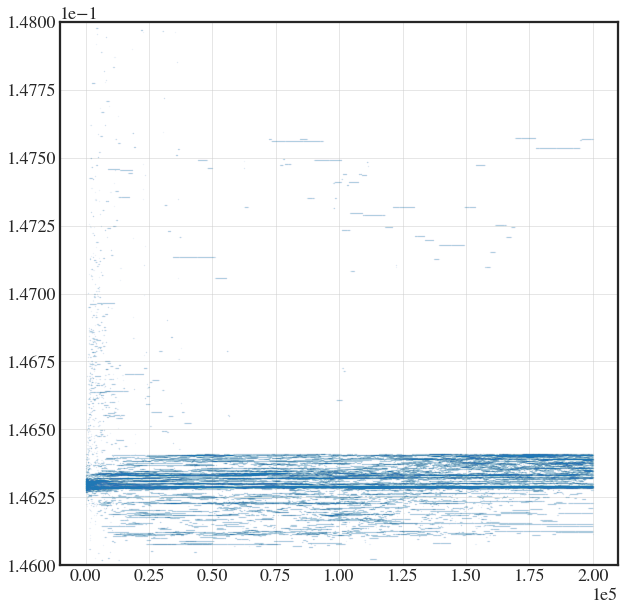

In [96]:
plt.figure(figsize=(10,10))
plt.scatter(np.arange(len(dl)), flat['vphot'], s=0.1, alpha=0.1)
plt.ylim(0.146, 0.148)

43.50230073063438 43.30151661270349 43.67830978733334


(43.50230073063438, 43.30151661270349, 43.67830978733334)

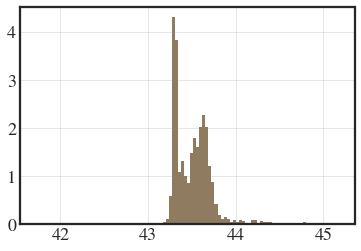

In [92]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], res2.params['vphot'], n_days=5.41 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

flat = res2.flatchain
steady = 0#100*nwalkers
dl = lum_dist_arr( flat['N'][steady:], res2.params['vphot'], n_days=5.41 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

In [74]:
#with open("./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [73]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3074.44908,4.05048285,(0.13%),3072.9062936578944,2500.00000,7500.00000,True
N,3.6091e-29,3.7977e-31,(1.05%),3.617769596181866e-29,-inf,inf,True
vphot,0.14629930,1.2770e-04,(0.09%),0.14640500352296562,0.00000000,1.00000000,True
vmax,0.21924834,1.9094e-04,(0.09%),0.21940724330370415,0.00000000,1.00000000,True
t0,471600.000,,(0.09%),471600,-inf,inf,False
tau,0.16020896,6.1667e-04,(0.38%),0.15889245689963946,0.00000000,10.0000000,True
vref,0.00000000,,(0.38%),0.0,0.00000000,1.00000000,False
ve,0.32905074,0.05398227,(16.41%),0.3289573444095824,0.00000000,1.00000000,True
occult,22.3658589,2.63707303,(11.79%),22.264930789253874,0.10000000,40.0000000,True
amp1,1.16175499,0.01285254,(1.11%),1.1542595378679568,0.01000000,5.00000000,True


43.64040256558803 43.50228983521025 43.7272393814102


(43.64040256558803, 43.50228983521025, 43.7272393814102)

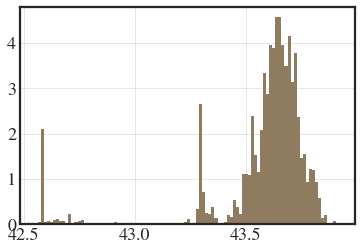

In [85]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], res2.params['vphot'], n_days=5.41 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

flat = res2.flatchain
steady = 0#100*nwalkers
dl = lum_dist_arr( flat['N'][steady:], res2.params['vphot'], n_days=5.41 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

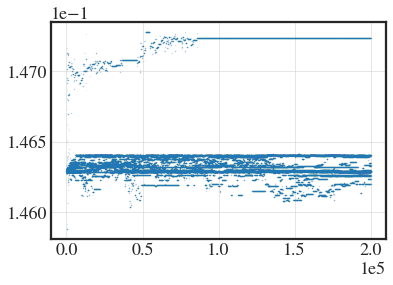

In [86]:
plt.scatter(np.arange(len(dl)), flat['vphot'], s=0.1, alpha=0.1)

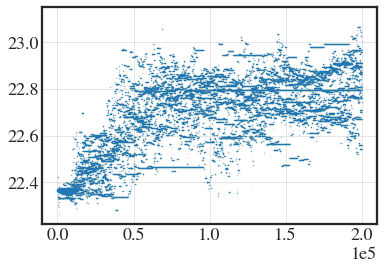

In [88]:
plt.scatter(np.arange(len(dl)), flat['occult'], s=0.1, alpha=0.1)

In [87]:
res2.acceptance_fraction

array([0.0461, 0.0359, 0.0421, 0.0539, 0.0382, 0.0497, 0.054 , 0.031 ,
       0.0457, 0.0214, 0.0555, 0.047 , 0.0312, 0.0444, 0.0375, 0.0273,
       0.0351, 0.0458, 0.0551, 0.0381])

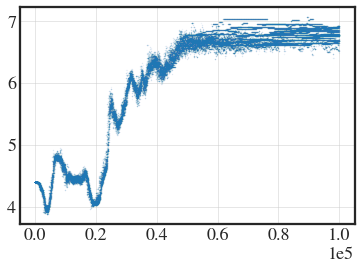

In [58]:
plt.scatter(np.arange(len(dl)), flat['occult'], s=0.1, alpha=0.1)

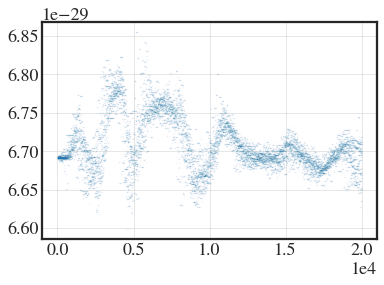

In [53]:
plt.scatter(np.arange(len(dl)), flat['N'], s=0.1, alpha=0.1)

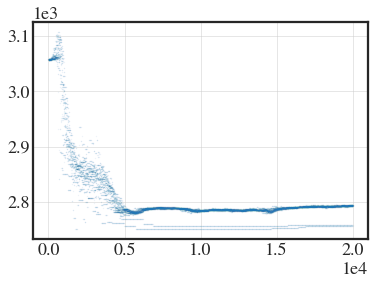

In [44]:
plt.scatter(np.arange(len(dl)), flat['T'], s=0.1, alpha=0.1)

In [15]:
#with open("./Data/OB5/OB5_3_filtered_short.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 
    

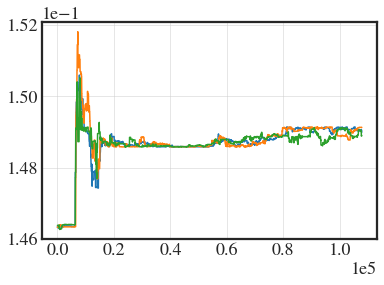

In [19]:
plt.plot(flat['vphot'][::22])
plt.plot(flat['vphot'][1::22])
plt.plot(flat['vphot'][2::22])

In [16]:
#with open("./Data/OB4/OB4_3_peaks.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

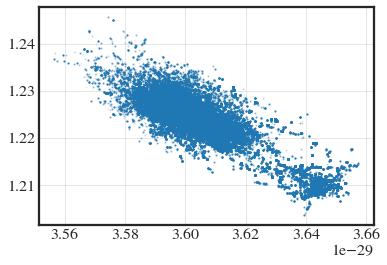

In [73]:
plt.scatter(flat['N'], flat['amp2'],s=1, alpha=0.1)

In [77]:
#plt.scatter(flat['N'], flat['sig2'],s=1, alpha=0.1)


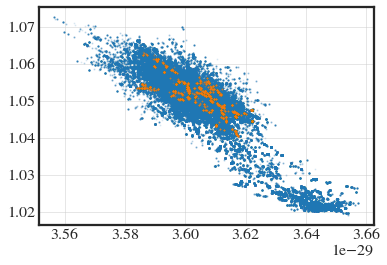

In [69]:
plt.scatter(flat['N'], flat['amp1'],s=1, alpha=0.1)
plt.scatter(flat['N'][-10000:], flat['amp1'][-10000:],s=1, alpha=0.1)

43.37528234154239 43.15963701254104 44.068235109238735


(44.105267351342064, 43.96631826980392, 44.21413263465056)

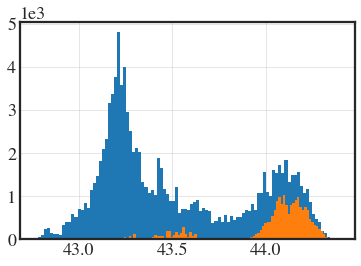

In [20]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=5.4 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

steady = nwalkers*4000
flat = res2.flatchain
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=5.4 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

In [10]:
import corner

NameError: name 'flat' is not defined

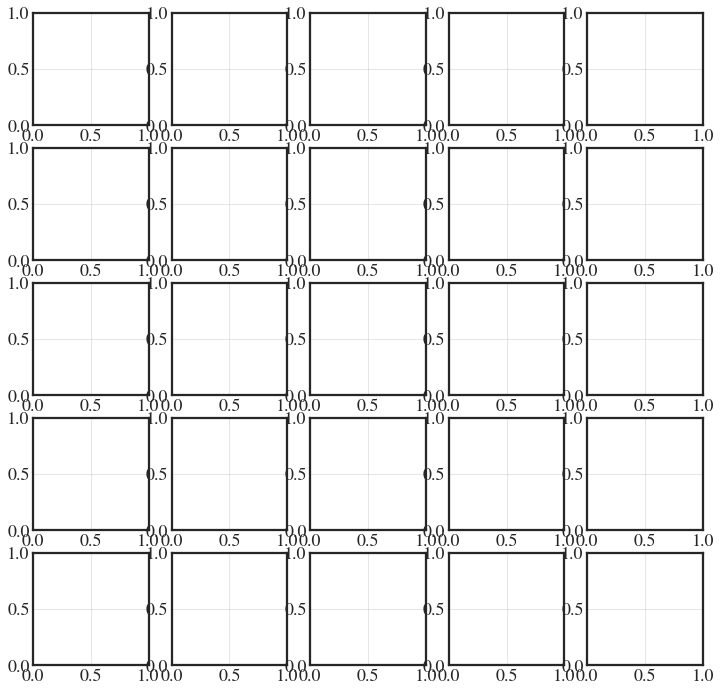

In [11]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['ve']]).T, 
                           labels=['T', 'N', 'vphot','vmax', 've'], show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

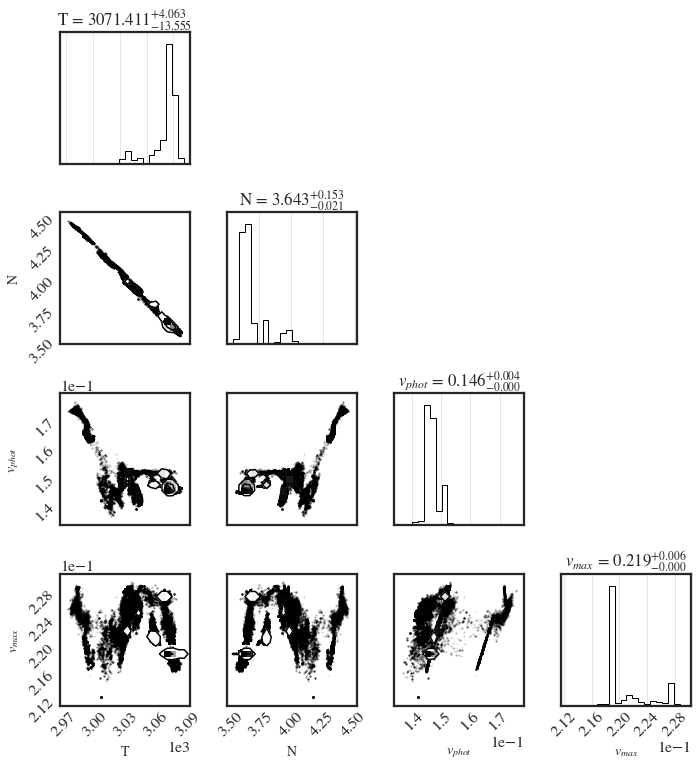

In [44]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,11),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB5_covariance_small.png', dpi=300)

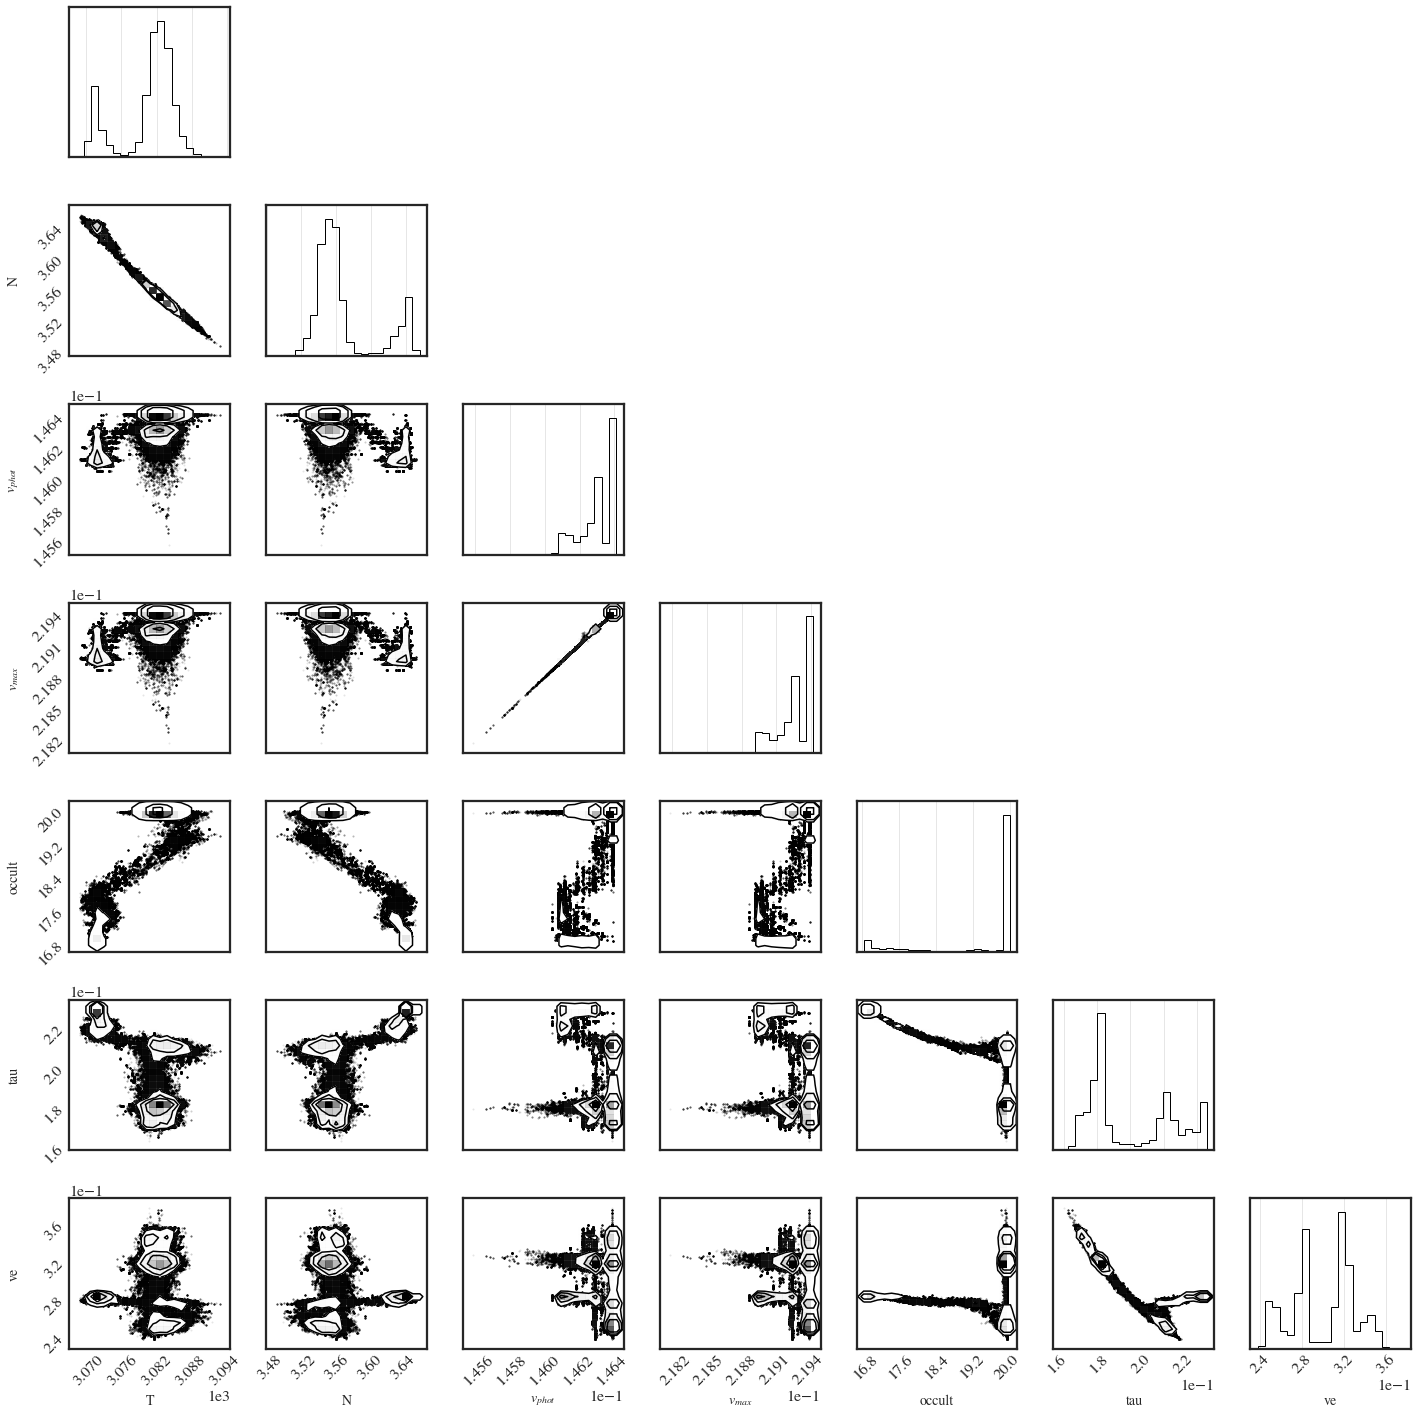

In [98]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,20),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$',r'$v_{max}$','occult','tau','ve'], 
              show_titles=False, fig=fig, title_fmt = '.3f'); 
plt.tight_layout()

#plt.savefig('Pictures/OB5_covariance_large.png', dpi=300)

In [ ]:
#with open("./Data/OB4/OB4_3.pkl", 'wb') as outfile:
#    pickle.dump(res, outfile)